In [1]:
import msprime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import random
import math
from tqdm import tqdm
from matplotlib.cm import ScalarMappable
import multiprocessing
import istarmap
import itertools
from scipy.stats import gaussian_kde
import torch
from priors import *
from SMC_DRF import DataSimulator
from MSPIDNA_SMC_ABC_RF import Experiment
from priors import generate_prior
import SMC_DRF
from SMC_DRF import *
import rpy2.robjects as robjects

# Testing a pre-trained MSPIDNA on generated data data

Pre-trained MSPIDNA are provided for following priors on the mutation rate : 

- $[1e-7,1e-5]$ with model_custom_exp_name="low_mr"
- $[1e-6,1e-4]$ with model_custom_exp_name="high_mr"
- $[1e-5,1e-3]$ with model_custom_exp_name="vh_mr"

All other parameters set to default value except for null_diag and full_seq that you can change to true or false while being able to use a pre-trained MSPIDNA (mspidna_training=False)

In [ ]:
'''
Parameters of the experiment:
- nb_samples_mspidna_training: number of data points to generate for the training of MSPIDNA (summary-statistics generator)
- nb_samples_abc_step: number of data points to generate for an ABC step (posterior inference)
- sample_size: number of individual sampled in each data point
- population_size: total size of the population
- sequence_length: length of the sequences (in base pairs)
- len_seq_final: length of the final sequences (number of base pairs kept)
- mr_min: minimum mutation rate for the prior
- mr_max: maximum mutation rate for the prior
- root_distribution: nucleotides distribution in the ancestral sequence
- null_diag: boolean to have a null diagonal in the transition matrix
- full_seq: boolean to generate with the "full-sequence" approach or "SNPS-only" approach
- nb_iter: number of iterations T 
- idx_start, idx_end : |end index - start and + 1| is the number of points to infer
- nb_iter_start: start iteration for the ABC-SMC-RF (usually 1 if we didn't already run it for the specified idx)
- nb_iter_end: end iteration for the ABC-SMC-RF 
- real: boolean to use real data or generated data (empirically root_distribution=[0.32,0.23,0.29,0.16] for mtDNA)
- model_custom_exp_name: prior-specific name for the experiment (for the file names saved)
- custom_exp_name: custom experiment name (for the file names saved)
- mspidna_training: boolean to train MSPIDNA or not (not necessary if already trained for the specified prior)

Outputs:
everything in Experiments_data/ folder
- The data folder containing the data points : exp.data_folder
- The results folder containing the results and plot : exp.results_folder
'''


experiment = Experiment(nb_samples_mspidna_training=5000, nb_samples_abc_step=5000, sample_size=100, population_size=1000, sequence_length=4000, len_seq_final=4000,
                mr_min=1e-5, mr_max=1e-3, 
                root_distribution=[0.25,0.25,0.25,0.25], 
                null_diag=False, full_seq=True, #pre-trained MSPIDNA provided for all values of null_diag and full_seq
                nb_iter=1, idx_start=0, idx_end=0, nb_iter_start=1, nb_iter_end=5, real=False, 
                model_custom_exp_name="high_mr", 
                custom_exp_name="", mspidna_training=False)

experiment.run()

# Plotting functions 
#### For a new experiment new_exp, you need to run it with new_exp.run() before using the plotting functions

In [ ]:
exp = Experiment(mr_min=1e-7, mr_max=1e-5, null_diag=False, full_seq=True, real=True, model_custom_exp_name="low_mr", mspidna_training=False)

nb_iter = 5
idx = 0
#plot mutation rate posterior
plot_1D_posterior_custom(idxs_to_plot = [0], nb_iter = nb_iter, idx = idx, results_folder = exp.results_folder)

#plot transition matrix posterior
plot_1D_posteriors(nb_iter = nb_iter, idx = idx, results_folder = exp.results_folder)

#plot a 2D posterior of 2 parameters
i,j = 1, 2
plot_2D_posterior(i, j, nb_iter = nb_iter, idx = idx, results_folder = exp.results_folder, subfolder = f'prior_{nb_iter}/')

#Merge the plot of 2D posteriors for all different combination of (i,j) already plotted
merge_2D_posteriors(idx = idx, results_folder = exp.results_folder, subfolder = f'prior_{nb_iter}/')

In [ ]:
exp1 = Experiment(mr_min=1e-7, mr_max=1e-5, null_diag=False, full_seq=True, real=True, model_custom_exp_name="low_mr", mspidna_training=False)
exp2 = Experiment(mr_min=1e-6, mr_max=1e-4, null_diag=False, full_seq=True, real=True, model_custom_exp_name="high_mr", mspidna_training=False)
exp3 = Experiment(mr_min=1e-5, mr_max=1e-3, null_diag=False, full_seq=True, real=True, model_custom_exp_name="vh_mr", mspidna_training=False)
exps = [exp1, exp2, exp3]

#compare transition matrix posterior prediction for different experiments (and same objective data...)
compare_1D_posteriors(nb_iter, idx, results_folders = [exp.results_folder for exp in exps])

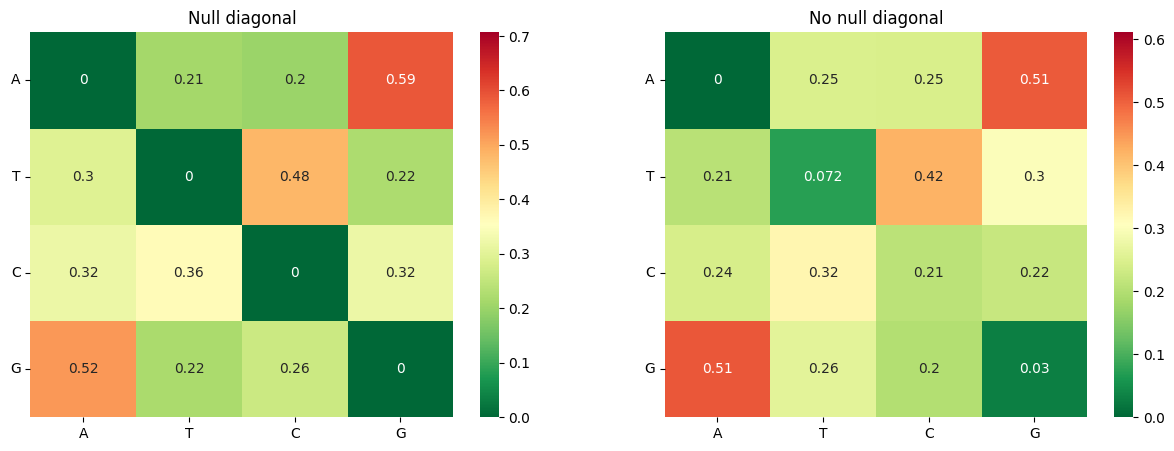

In [3]:
exp2 = Experiment(mr_min=1e-7, mr_max=1e-5, null_diag=False, full_seq=True, real=True, model_custom_exp_name="low_mr", mspidna_training=False)
exp1 = Experiment(mr_min=1e-7, mr_max=1e-5, null_diag=True, full_seq=True, real=True, model_custom_exp_name="low_mr", mspidna_training=False)
exps = [exp1, exp2]
nb_iter = 5
idx = 0
fig, axes = plt.subplots(1,2, figsize=(15,5))

for i, ax in enumerate(axes):
    Y = torch.load(exps[i].data_folder + f'prior_{nb_iter+1}/Y_{idx}_prior_{nb_iter+1}.pt', weights_only=False)
    if exps[i].null_diag:
        cond_exp_est = Y.mean().values[1:]
        #add 0 at positions 0, 5, 10, 15
        cond_exp_est = np.insert(cond_exp_est, 0, 0, axis=0)
        cond_exp_est = np.insert(cond_exp_est, 5, 0, axis=0)
        cond_exp_est = np.insert(cond_exp_est, 10, 0, axis=0)
        cond_exp_est = np.insert(cond_exp_est, 15, 0, axis=0)
        cond_exp_est = cond_exp_est.reshape(4,4)
    else:
        cond_exp_est = Y.mean().values[1:].reshape(4,4)
        min_diag = min([cond_exp_est[0][0], cond_exp_est[1][1], cond_exp_est[2][2], cond_exp_est[3][3]])
        for j in range(4): #equivalent to time rescaling
            cond_exp_est[j][j]-= min_diag
        #normalize rows
        cond_exp_est = cond_exp_est / cond_exp_est.sum(axis=1)[:, np.newaxis]
    #plot sns heatmap matrix of the posterior
    cmap = sns.color_palette("RdYlGn_r", as_cmap=True)

    # Tracer la heatmap
    sns.heatmap(cond_exp_est, ax=ax, cmap=cmap, annot=True, cbar=True, vmin=0, vmax=1.2*cond_exp_est.max())
    if exps[i].null_diag:
        ax.set_title(f'Null diagonal')
    else:
        ax.set_title(f'No null diagonal')
    # Définir les étiquettes personnalisées pour les axes x et y
    ax.set_xticklabels(['A', 'T', 'C', 'G'])
    ax.set_yticklabels(['A', 'T', 'C', 'G'], rotation=0)
plt.show()

# RMSD / AED

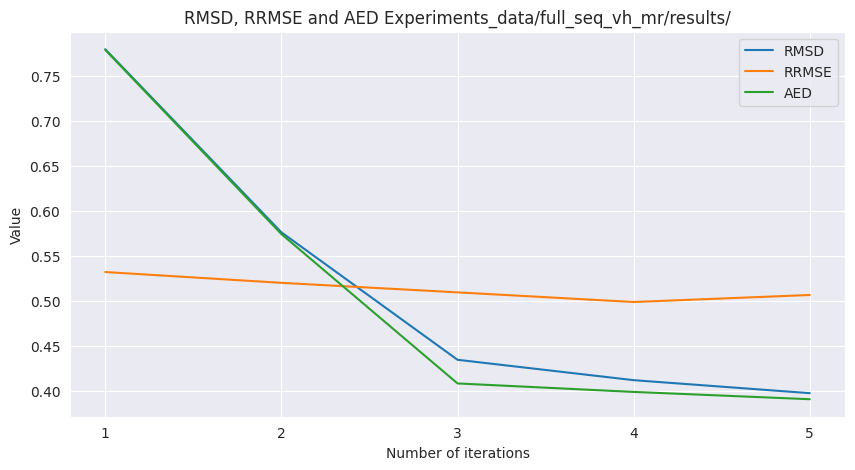

In [29]:
exp = Experiment(mr_min=1e-5, mr_max=1e-3, null_diag=False, full_seq=True, real=False, model_custom_exp_name="vh_mr", mspidna_training=False)

#calculate RMSD, AED and RRMSE
rmsds = []
aeds = []
rrmses = []
for iter in range (1,exp1.nb_iter_end+1):
    subfolder = f'prior_{iter}/'
    test_mr = pd.DataFrame(pd.read_csv(exp.results_folder + f"mse_{iter}.csv")).iloc[:,0]
    p = test_mr.shape[0]
    mr_norm2_mean = test_mr.mean()
    normalisation = 0
    for idx in range(exp.idx_start,exp.idx_end+1):
        if iter!=1:
            Y_posterior = pd.read_csv(exp.results_folder+subfolder+f'Ydrf_{idx}_prior_{iter}.csv')
        else:
            Y_posterior = pd.read_csv(exp.results_folder+subfolder+f'Ydrf_{idx}_prior_{iter}.csv')
        mse =  (Y_posterior.mean(axis=0).iloc[0])**2
        normalisation += mse
    normalisation = np.sqrt(normalisation/(exp.idx_end+1-exp.idx_start))
    #transition parameters
    test = pd.DataFrame(pd.read_csv(exp.results_folder + f"mse_{iter}.csv")).iloc[:,1:]
    #L2 Norm of the parameters
    test["norm2"] = np.linalg.norm(test.values, ord=1, axis=1)
    test["norm"] = np.sqrt(test["norm2"])
    norm2_mean = test["norm2"].mean()
    norm_mean = test["norm"].mean()
    norm2_std = test["norm2"].std()
    norm_std = test["norm"].std()
    #print(f"MR RMSD: {np.sqrt(mr_norm2_mean)}")
    #print(f"MR RRMSE: {(np.sqrt(mr_norm2_mean)/normalisation):.3f}")
    #print(f"RMSD: {np.sqrt(norm2_mean):.3f} +/- {norm2_std/(4*norm2_mean):.3f}")
    #print(f"AED norm mean : {norm_mean:.3f} +/- {norm_std:.3f}")
    rmsds.append(np.sqrt(norm2_mean))
    rrmses.append(np.sqrt(mr_norm2_mean)/normalisation)
    aeds.append(norm_mean)

#plot rmsd, rrmse, aed, mrrmsd in function of iter
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
plt.plot(range(1,6), rmsds, label="RMSD")
plt.plot(range(1,6), rrmses, label="RRMSE")
plt.plot(range(1,6), aeds, label="AED")
plt.xlabel("Number of iterations")
plt.xticks(np.arange(1, 6, 1))
plt.ylabel("Value")
plt.legend(loc="best")
plt.title(f"RMSD, RRMSE and AED {exp.results_folder}")
plt.show()

# Assess results from MSPIDNA-SMC-ABC-RF

## Markov Chain assumptions

In [ ]:
#Markov Chain method 
N=4000 # number of nucleotides
k=1000 # number of generations
M=100 # number of descendants
ancestor = torch.load("real_ancestor.pt")  # Ancestor sequence
descendants= torch.load("real_descendants.pt") # Descendants
def transition_matrix(ancestor, descendants):
  def q(i,j):
    return sum(sum(ancestor[m]==i and descendants[l][m]==j for m in range(N)) for l in range(M))/(M*(sum(ancestor[m]==i for m in range(N))))
  def matrix_Q():
    Q=np.zeros((4,4))
    for i in range(4):
      for j in range(4):
        Q[i][j]=q(i,j)
    return Q
  Q=np.array(matrix_Q())
  # solve Q=Id+k(P-Id)+k^2 (P-Id)^2
  # Q-Id=k(P-Id)+k^2 (P-Id)^2
  # R=Q-Id, A=k(P-Id), we want R=A+A^2, at first order A=R, A=R+H, R=(R+H)+(R+H)^2, H+R^2=0 approx, H=-R^2, A=R-R^2
  # P=A/k+Id, P=((Q-Id)-(Q-Id)^2/2)/k +Id
  P=np.zeros((N,N))
  # return P defined by ((Q-Id)-(Q-Id)^2/2)/k +Id
  P=((Q-np.eye(4))-np.dot(Q-np.eye(4), Q-np.eye(4))/2)/k + np.eye(4)
  #print(Q)
  for i in range(4):
    P = np.maximum(P, 0)
    P[i][i]=0
    P[i]=P[i]/sum(P[i])
  return P

P=transition_matrix(ancestor, descendants)

print(P)

[[0.         0.00652157 0.         0.99347843]
 [0.03166743 0.         0.96833257 0.        ]
 [0.         1.         0.         0.        ]
 [0.97609275 0.         0.02390725 0.        ]]


In [ ]:
# Test markov chain method
simulator = DataSimulator(nb_samples=20,root_distribution=[0.32,0.25,0.12,0.31], full_seq=True, real=False)
mutation_rates = generate_prior(type="uniform", a=[1e-5], b=[1e-3], nb_points=20)[0]
transition_matrices = generate_prior(type="dirichlet_transition_matrix", n=4, nb_points=20, null_diag=True)
rmsd = 0
count = 0
for i in range(20):
    args = (mutation_rates[i].numpy(), transition_matrices[i].numpy(), [0.32,0.25,0.12,0.31])
    ancestor, descendants = simulator.simulate2(args)
    
    P=transition_matrix(ancestor, descendants)
    rmsd += ((P - transition_matrices[i].numpy())**2).sum()
    count += 1
rmsd /= count
rmsd = np.sqrt(rmsd)
print(rmsd)

0.37076097974426125


## Generate new data from posterior mean

In [ ]:
exp = Experiment(mr_min=1e-7, mr_max=1e-5, null_diag=False, full_seq=True, real=True, model_custom_exp_name="low_mr", mspidna_training=False, root_distribution=[0.32,0.23,0.29,0.16])

nb_iter = 5
idx = 0

Y = torch.load(exp.data_folder + f'prior_{nb_iter+1}/Y_{idx}_prior_{nb_iter+1}.pt', weights_only=False)
if exp.null_diag:
    cond_exp_est = Y.mean().values[1:]
    #add 0 at positions 0, 5, 10, 15
    cond_exp_est = np.insert(cond_exp_est, 0, 0, axis=0)
    cond_exp_est = np.insert(cond_exp_est, 5, 0, axis=0)
    cond_exp_est = np.insert(cond_exp_est, 10, 0, axis=0)
    cond_exp_est = np.insert(cond_exp_est, 15, 0, axis=0)
    cond_exp_est = cond_exp_est.reshape(4,4)
else:
    cond_exp_est = Y.mean().values[1:].reshape(4,4)
theta_pred = Y.mean().values[0]

res_finale = np.zeros((4))
for k in range(100):
    sim = exp.simulate_dataset(theta_pred,cond_exp_est)
    sim = sim[1:]
    res = sim.mean(axis=(0,1))
    #resize and normalize each row
    res = res.reshape(4,4)
    res_finale += res.sum(axis=1)
res_finale /= 100
print(res_finale)